# Task 1.1
-----------

Automatically created module for IPython interactive environment
Total dataset size:
n_samples: 981
n_features: 1850
n_classes: 5
Extracting the top 190 eigenfaces from 735 faces
done in 0.085s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.011s
Fitting the classifier to the training set
done in 24.621s
Best estimator found by grid search:
SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting people's names on the test set
done in 0.029s
                   precision    recall  f1-score   support

     Ariel Sharon       0.78      0.78      0.78        18
  Donald Rumsfeld       0.78      0.85      0.81        33
    George W Bush       0.90      0.96      0.93       124
Gerhard Schroeder       0.85      0.77      0.81        30
       Tony Blair       0.94      0.76      0.84   

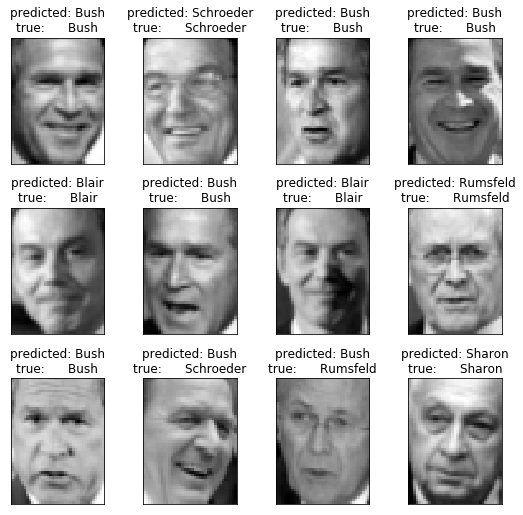

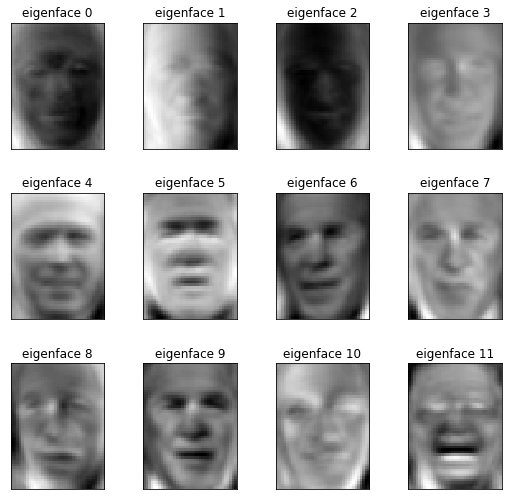

25.485674570998526
(246,)
(246,)


In [19]:
from __future__ import print_function
from timeit import default_timer
from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.svm import LinearSVC as svc
start = default_timer()
print(__doc__)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')


# #############################################################################
# Download the data, if not already on disk and load it as numpy arrays

lfw_people_unfunneled = fetch_lfw_people(min_faces_per_person=70, funneled=False, resize=0.4)
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4,funneled=True)



# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)


# #############################################################################
# Split into a training set and a test set using a stratified k fold

# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)


# #############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 190

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))


# #############################################################################
# Train a SVM classification model

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1,10,100,1e3],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                   param_grid, cv=5)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)


# #############################################################################
# Quantitative evaluation of the model quality on the test set

print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

n_values = [50,150,190,300]
f1_scores = [0.85,0.86,0.87,0.83]

# #############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()
duration = default_timer() - start
print(duration)
print(y_pred.shape)
print(y_test.shape)


# Task1.2:
--------------------

Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

--------------
Here the 'c' is relatively large the 'c' that is found when using PCA and that is due to it is heavily penalized for misclassified data as it contains all the feautures when not using PCA.

# Task 1.3:
-----------


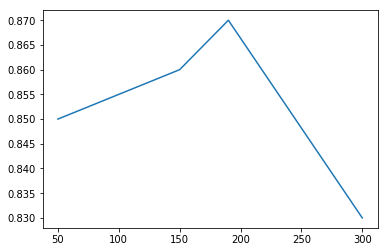

In [11]:
plt.plot([50,150,190,300,700], [0.84,0.87,0.88,0.83,0.68])

# Task 1.4:
---------
The increasing range up to 190 principal component gave improving result till we reached the best score at 190, and that is due to the necessity of having that number of components to train our model correctly, however, the increasing range from 190 up to 700 gave decreasing results, as those features are thought of as noise or maybe inclusions of unintended features such as foreground objects.

# Task 1.5:
---------

Principal components: 190
SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
                   precision    recall  f1-score   support

     Ariel Sharon       0.78      0.78      0.78        18
  Donald Rumsfeld       0.78      0.85      0.81        33
    George W Bush       0.90      0.96      0.93       124
Gerhard Schroeder       0.85      0.77      0.81        30
       Tony Blair       0.94      0.76      0.84        41

      avg / total       0.88      0.87      0.87       246

[[ 14   2   2   0   0]
 [  0  28   4   1   0]
 [  3   0 119   2   0]
 [  0   2   3  23   2]
 [  1   4   4   1  31]]


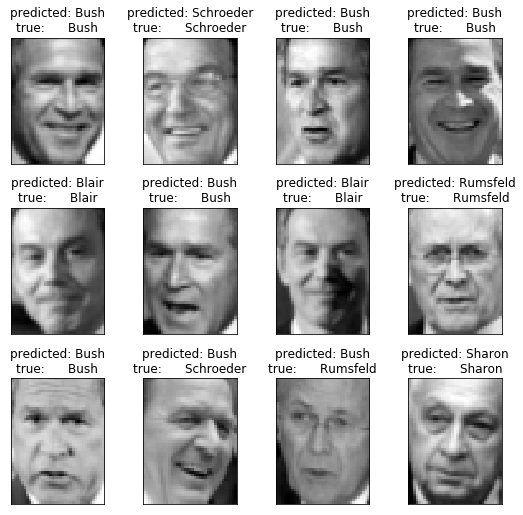

In [20]:
print("Principal components:", n_components)
print(clf.best_estimator_)
print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))
plot_gallery(X_test, prediction_titles, h, w)

# Task 1.6:
---------------

                   precision    recall  f1-score   support

     Ariel Sharon       0.80      0.62      0.70        13
     Colin Powell       0.79      0.87      0.83        60
  Donald Rumsfeld       0.65      0.74      0.69        27
    George W Bush       0.87      0.86      0.86       146
Gerhard Schroeder       0.71      0.68      0.69        25
      Hugo Chavez       0.59      0.67      0.62        15
       Tony Blair       0.73      0.61      0.67        36

      avg / total       0.79      0.79      0.79       322

[[  8   1   2   1   0   1   0]
 [  0  52   1   3   1   1   2]
 [  1   1  20   2   1   0   2]
 [  1   4   8 125   2   3   3]
 [  0   1   0   5  17   1   1]
 [  0   2   0   2   1  10   0]
 [  0   5   0   6   2   1  22]]


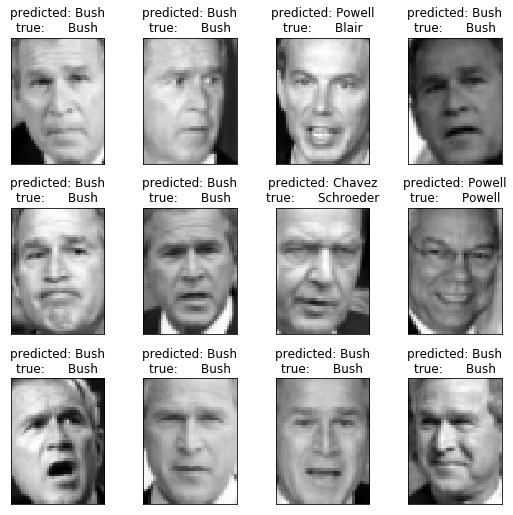

In [10]:
print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))
plot_gallery(X_test, prediction_titles, h, w)

# Task 1.7:
----------------

Using the image funnel allowed aligning images under complex backgrounds, lighting, and foreground appearance. Which improves positioning for subsequent identification, thus, the unfunneled version suffers from some kind of uncertainty related to deviations in the test dataset images' poses rather than the trained canonical poses. 

# Task 1.8:
--------------

{
Jupyter: "25.948098983988166", 
Collab:"91.54126909800004", 
GPU: "32.18555887999992", 
TPU: "44.2090466980003"
}

# Task 2:
-------------

In [1]:
import collections
import os
import pandas as pd
import numpy as np

In [2]:
dfx_train = pd.read_csv('14cancer.xtrain.csv', delim_whitespace=True, header=None)
dfx_test =  pd.read_csv('14cancer.xtest.csv', delim_whitespace=True, header=None)
defy_train =  pd.read_csv('14cancer.ytrain.csv', delim_whitespace=True, header=None)
defy_test =  pd.read_csv('14cancer.ytest.csv', delim_whitespace=True, header=None)

In [3]:
X_train = np.array(dfx_train)
X_test = np.array(dfx_test)
y_train = np.array(defy_train)
y_test = np.array(defy_test)
y_test.shape

(1, 54)

In [4]:
X_train = X_train.T
X_test = X_test.T
y_train = y_train.T
y_test = y_test.T
X_test.shape

(54, 16063)

In [5]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
# X_train.shape

(144, 16063)
(54, 16063)
(144, 1)
(54, 1)


# Task 2.1:
-------------

In [6]:
from time import time
import numpy as np
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC as svc
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV



svm = OneVsRestClassifier(SVC(kernel="linear"))

svm.fit(X_train,y_train)
print(svm.score(X_test,y_test))





0.7777777777777778


In [7]:
from time import time
import numpy as np
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC as svc
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt


t0 = time()
n_components = 90
resultsTest = []
resultsTrain = []
while n_components < 125:
    
    pca = PCA(n_components=n_components, svd_solver='randomized').fit(X_train)
    print("done in %0.3fs" % (time() - t0))

    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)

    svm = OneVsRestClassifier(SVC(kernel="linear"))
    parameters = {
        "estimator__C": [1,2,4,8,10,100,1e3],
        "estimator__kernel": ["poly","rbf",],
        "estimator__degree":[1, 2, 3, 4, 5, 6, 7],
    }    
    tuner = GridSearchCV(svm, param_grid=parameters,cv=7)

    tuner.fit(X_train_pca, y_train)
    resultsTrain.append(tuner.best_score_)
    resultsTest.append(tuner.score(X_test_pca,y_test))
    n_components+=5
    print ("No. of components:" , n_components-5 ,", Best Score: ", tuner.best_score_,"Test Score:" ,tuner.score(X_test_pca,y_test))
    print (tuner.best_params_)
    
plt.plot([90,95,100,105,110,115,120], resultsTest)
plt.plot([90,95,100,105,110,115,120], resultsTrain)

# Task 2.1.c: No generalization nor overfitting, the test scores vary very slightly

done in 0.314s
No. of components: 90 , Best Score:  0.6666666666666666 Test Score: 0.6296296296296297
{'estimator__C': 1, 'estimator__degree': 1, 'estimator__kernel': 'poly'}
done in 26.724s
No. of components: 95 , Best Score:  0.6736111111111112 Test Score: 0.6481481481481481
{'estimator__C': 1, 'estimator__degree': 1, 'estimator__kernel': 'poly'}
done in 55.411s
No. of components: 100 , Best Score:  0.6458333333333334 Test Score: 0.6111111111111112
{'estimator__C': 1, 'estimator__degree': 1, 'estimator__kernel': 'poly'}
done in 87.788s
No. of components: 105 , Best Score:  0.6458333333333334 Test Score: 0.6481481481481481
{'estimator__C': 1, 'estimator__degree': 1, 'estimator__kernel': 'poly'}
done in 117.918s
No. of components: 110 , Best Score:  0.6527777777777778 Test Score: 0.6481481481481481
{'estimator__C': 1, 'estimator__degree': 1, 'estimator__kernel': 'poly'}
done in 148.412s
No. of components: 115 , Best Score:  0.6458333333333334 Test Score: 0.6296296296296297
{'estimator_

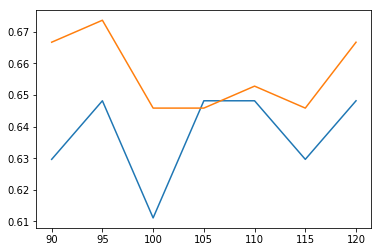

In [8]:
plt.plot([90,95,100,105,110,115,120], resultsTest)
plt.plot([90,95,100,105,110,115,120], resultsTrain)

# Task 2.2:
-----------
I have used one vs rest classifier, hence, for each classifier the class is fitted against all the other classes. Since each class is represented by one and one classifier only, it is possible to gain knowledge about the class by inspecting its corresponding classifier as the dataset is sensitive in dealing with the number of principal components.